In [1]:
import os
from exp_framework.Ensemble import Ensemble, PretrainedEnsemble, StudentExpertEnsemble
from exp_framework.delegation import (
    DelegationMechanism,
    UCBDelegationMechanism,
    ProbaSlopeDelegationMechanism,
    RestrictedMaxGurusDelegationMechanism,
    StudentExpertDelegationMechanism,
)
from exp_framework.learning import Net
from exp_framework.experiment import (
    Experiment,
    calculate_avg_std_test_accs,
    calculate_avg_std_train_accs,
)
from avalanche.training.supervised import Naive
from matplotlib import pyplot as plt
from exp_framework.data_utils import Data
from avalanche.benchmarks.classic import RotatedMNIST, SplitMNIST
import numpy as np
import matplotlib as mpl
import seaborn as sns
from itertools import product
import pandas as pd
import torch.optim as optim
from torch.nn import CrossEntropyLoss

from avalanche.training.plugins import (
    CWRStarPlugin,
    ReplayPlugin,
    EWCPlugin,
    TrainGeneratorAfterExpPlugin,
    LwFPlugin,
    SynapticIntelligencePlugin,
)
from exp_framework.MinibatchEvalAccuracy import MinibatchEvalAccuracy
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import accuracy_metrics

/Users/ben/VSCode/banditLiquidDem/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### learning the mapping $\mathcal{X} \rightarrow \mathcal{G}$ (i.e. $\mathcal{X} \rightarrow \mathcal{Y}\times\mathcal{C}$)

### Set up global experiment settings

In [2]:
batch_size = 128
window_size = 50
num_trials = 2
n_voters = 5

#### Create Delegation Mechanisms

### Create Delegation Mechanisms and Ensembles

For simplicity, only explore full ensemble and variants of ProbaSlopeDelegationMechanism since they can be created programmatically.

In [3]:
def get_ensembles_dict():

    NOOP_del_mech = DelegationMechanism(batch_size=batch_size, window_size=window_size)
    NOOP_del_mech2 = DelegationMechanism(batch_size=batch_size, window_size=window_size)

    probability_functions = [
        "random_better",
        "probabilistic_better",
        "probabilistic_weighted",
        "max_diversity"
    ]
    score_functions = [
        "accuracy_score",
        "balanced_accuracy_score",
        "f1_score",
        # "precision_score",
        # "recall_score",
        # "top_k_accuracy_score",
        # "roc_auc_score",
        # "log_loss_score",
        # "max_diversity",
    ]
    # probability_functions = ["max_diversity"]
    # score_functions = ["accuracy_score"]

    del_mechs = {"full-ensemble": NOOP_del_mech}
    for prob_func, score_func in product(probability_functions, score_functions):
        dm = ProbaSlopeDelegationMechanism(
            batch_size=batch_size,
            window_size=window_size,
            max_active=max_active_gurus,
            probability_function=prob_func,
            score_method=score_func,
        )
        del_mechs[f"{prob_func}-{score_func}"] = dm



    ensembles_dict = {
        dm_name: Ensemble(
            training_epochs=1,
            n_voters=n_voters,
            delegation_mechanism=dm,
            name=dm_name,
            input_dim=28 * 28,
            output_dim=10,
        )
        for dm_name, dm in del_mechs.items()
    }
    ensembles_dict["single_Net"] = Ensemble(
            training_epochs=1,
            n_voters=1,
            delegation_mechanism=NOOP_del_mech2,
            name="single_Net",
            input_dim=28 * 28,
            output_dim=10,
        )
    return ensembles_dict

#### Create Avalanche Strategies to Compare Against

In [4]:
def initialize_strategies_to_evaluate():
    plugins_to_evaluate = {
        "LwF": LwFPlugin(),
        "EWC": EWCPlugin(ewc_lambda=0.001),
        "SynapticIntelligence": SynapticIntelligencePlugin(si_lambda=0.5),
        # "Replay": ReplayPlugin(mem_size=100),
    }

    strategies_to_evaluate = {}
    for name, pte in plugins_to_evaluate.items():
        
        model = Net(input_dim=28 * 28, output_dim=10)
        optimize = optim.Adam(model.parameters(), lr=0.001)
        
        mb_eval = MinibatchEvalAccuracy()
        evp = EvaluationPlugin(
            accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
            mb_eval
        )
        cl_strategy = Naive(
            model=model,
            optimizer=optimize,
            criterion=CrossEntropyLoss(),
            train_mb_size=batch_size,
            train_epochs=1,
            eval_mb_size=batch_size,
            # plugins=[pte, evp],
            plugins=[pte, evp, mb_eval]
        )
        strategies_to_evaluate[name] = (cl_strategy, evp)
    
    return strategies_to_evaluate

# Single Active Voter

### Train Ensemble - single active voter

In [5]:
# Train ensembles - single guru

data = Data(data_set_name="rotated_mnist")
max_active_gurus = 1

ensembles_dict = get_ensembles_dict()

exp = Experiment(
    n_trials=num_trials,
    ensembles=list(ensembles_dict.values()),
    benchmark=data,
    strategies_to_evaluate=initialize_strategies_to_evaluate,
)
_ = exp.run()

  0%|          | 0/2 [00:00<?, ?it/s]/Users/ben/VSCode/banditLiquidDem/.conda/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:68: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Starting trial  0
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 186.96it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1827
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9735
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 192.39it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1733
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9819
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 177.77it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.2210
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9709
-- >> End of training phase << --


### Save and Print Results

In [ ]:
batch_metrics = exp.get_aggregate_batch_metrics()
dfs = []
for ens, metric_dict in batch_metrics.items():
    df = pd.DataFrame.from_dict(metric_dict, orient="index")
    df["ensemble_name"] = ens
    dfs.append(df)
single_active_df = pd.concat(dfs)
col_order = [len(single_active_df.columns) - 1] + list(range(len(single_active_df.columns) - 1))
single_active_df = single_active_df[single_active_df.columns[col_order]]
file_prefix = f"class_incremental_single_guru-trials={num_trials}-batch_size={batch_size}_window_size={window_size}-max_num_gurus={max_active_gurus}"
path = "results"

if not os.path.exists(path):
    os.mkdir(path)

filepath = f"{path}/{file_prefix}.csv" 
single_active_df.to_csv(filepath)

In [ ]:
# Print results - single guru

print(f"Results for mechanisms with max_active_gurus = {max_active_gurus}:")

# Collect and print train accuracies - aggregate and by batch
train_results_dict = dict()
for ens_name, ensemble in ensembles_dict.items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(
        exp, ens_name, num_trials
    )
    train_results_dict[ens_name] = (train_acc, train_acc_std)

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(
        exp, strat_name, num_trials
    )
    train_results_dict[strat_name] = (train_acc, train_acc_std)

for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
    print(
        f"Mean train acc for {ens_name}: {round(np.mean(train_acc), 3)}+-{round(np.mean(train_acc_std), 3)}"
    )
# for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
#     print(f"All train accs for {ens_name}: {train_acc}")

print("--------------")

# Collect and print test accuracies
results_dict = dict()
for ens_name, ensemble in ensembles_dict.items():
    test_acc, test_acc_std = calculate_avg_std_test_accs(
        exp, ens_name, num_trials
    )
    results_dict[ens_name] = (test_acc, test_acc_std)

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    test_acc, test_acc_std = calculate_avg_std_test_accs(
        exp, strat_name, num_trials
    )
    results_dict[strat_name] = (test_acc, test_acc_std)

for ens_name, (test_acc, test_acc_std) in results_dict.items():
    print(
        f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.mean(test_acc_std), 3)}"
    )

Results for mechanisms with max_active_gurus = 1:
Mean train acc for full-ensemble: 0.865+-0.016
Mean train acc for random_better-accuracy_score: 0.855+-0.042
Mean train acc for random_better-balanced_accuracy_score: 0.87+-0.039
Mean train acc for random_better-f1_score: 0.829+-0.058
Mean train acc for probabilistic_better-accuracy_score: 0.849+-0.057
Mean train acc for probabilistic_better-balanced_accuracy_score: 0.84+-0.037
Mean train acc for probabilistic_better-f1_score: 0.865+-0.037
Mean train acc for probabilistic_weighted-accuracy_score: 0.872+-0.037
Mean train acc for probabilistic_weighted-balanced_accuracy_score: 0.876+-0.021
Mean train acc for probabilistic_weighted-f1_score: 0.856+-0.037
Mean train acc for max_diversity-accuracy_score: 0.813+-0.065
Mean train acc for max_diversity-balanced_accuracy_score: 0.859+-0.043
Mean train acc for max_diversity-f1_score: 0.864+-0.033
Mean train acc for single_Net: 0.852+-0.019
Mean train acc for LwF: 0.802+-0.023
Mean train acc for E

/Users/ben/VSCode/banditLiquidDem/.conda/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:68: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


# Many Active Voters

## Train Ensemble - many active voters


In [ ]:
# Run experiment - Many gurus

# Update max_active_gurus before calling get_ensembles_dict()
max_active_gurus = 3
data = Data(data_set_name="rotated_mnist")

ensembles_dict = get_ensembles_dict()

exp = Experiment(
    n_trials=num_trials,
    ensembles=list(ensembles_dict.values()),
    benchmark=data,
    strategies_to_evaluate=initialize_strategies_to_evaluate,
)
_ = exp.run()

  0%|          | 0/2 [00:00<?, ?it/s]

Starting trial  0
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 167.75it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0976
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9876
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 170.03it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0933
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9863
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 131.24it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0913
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9860
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:00<00:00, 164.24it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.1815
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8351
-- >> End of training phase << -

 50%|█████     | 1/2 [01:06<01:06, 66.21s/it]

Starting trial  1


/Users/ben/VSCode/banditLiquidDem/.conda/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:68: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 167.97it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.1000
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9847
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 164.52it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0705
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9878
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 99/99 [00:00<00:00, 139.60it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 0.0885
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.9885
-- >> End of training phase << --
-- >> Start of training phase << --
100%|██████████| 95/95 [00:00<00:00, 146.99it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3219
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.8351
-- >> End of training phase << --
-- >> Start of t

100%|██████████| 2/2 [02:13<00:00, 66.94s/it]


### Save and Print Results

In [ ]:
batch_metrics = exp.get_aggregate_batch_metrics()
dfs = []
for ens, metric_dict in batch_metrics.items():
    df = pd.DataFrame.from_dict(metric_dict, orient="index")
    df["ensemble_name"] = ens
    dfs.append(df)

many_active_df = pd.concat(dfs)
col_order = [len(many_active_df.columns) - 1] + list(range(len(many_active_df.columns) - 1))
many_active_df = many_active_df[many_active_df.columns[col_order]]
file_prefix = f"class_incremental_single_guru-trials={num_trials}-batch_size={batch_size}_window_size={window_size}-max_num_gurus={max_active_gurus}"
path = "results"

if not os.path.exists(path):
    os.mkdir(path)

filepath = f"{path}/{file_prefix}.csv" 
many_active_df.to_csv(filepath)

In [ ]:
# Print results - many gurus

print(f"Results for mechanisms with max_active_gurus = {max_active_gurus}:")

# Collect and print train accuracies - aggregate and by batch
train_results_dict = dict()
for ens_name, ensemble in ensembles_dict.items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(
        exp, ens_name, num_trials
    )
    train_results_dict[ens_name] = (train_acc, train_acc_std)

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    train_acc, train_acc_std = calculate_avg_std_train_accs(
        exp, strat_name, num_trials
    )
    train_results_dict[strat_name] = (train_acc, train_acc_std)

for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
    print(
        f"Mean train acc for {ens_name}: {round(np.mean(train_acc), 3)}+-{round(np.mean(train_acc_std), 3)}"
    )
# for ens_name, (train_acc, train_acc_std) in train_results_dict.items():
#     print(f"All train accs for {ens_name}: {train_acc}")

print("--------------")

# Collect and print test accuracies
results_dict = dict()
for ens_name, ensemble in ensembles_dict.items():
    test_acc, test_acc_std = calculate_avg_std_test_accs(
        exp, ens_name, num_trials
    )
    results_dict[ens_name] = (test_acc, test_acc_std)

for strat_name, (strat, eval_plugin) in initialize_strategies_to_evaluate().items():
    test_acc, test_acc_std = calculate_avg_std_test_accs(
        exp, strat_name, num_trials
    )
    results_dict[strat_name] = (test_acc, test_acc_std)

for ens_name, (test_acc, test_acc_std) in results_dict.items():
    print(
        f"Mean test acc for {ens_name}: {round(np.mean(test_acc), 3)}+-{round(np.mean(test_acc_std), 3)}"
    )

Results for mechanisms with max_active_gurus = 3:
Mean train acc for full-ensemble: 0.859+-0.016
Mean train acc for random_better-accuracy_score: 0.858+-0.032
Mean train acc for random_better-balanced_accuracy_score: 0.859+-0.029
Mean train acc for random_better-f1_score: 0.864+-0.021
Mean train acc for probabilistic_better-accuracy_score: 0.882+-0.015
Mean train acc for probabilistic_better-balanced_accuracy_score: 0.885+-0.02
Mean train acc for probabilistic_better-f1_score: 0.88+-0.02
Mean train acc for probabilistic_weighted-accuracy_score: 0.884+-0.011
Mean train acc for probabilistic_weighted-balanced_accuracy_score: 0.875+-0.022
Mean train acc for probabilistic_weighted-f1_score: 0.882+-0.014
Mean train acc for max_diversity-accuracy_score: 0.867+-0.018
Mean train acc for max_diversity-balanced_accuracy_score: 0.853+-0.021
Mean train acc for max_diversity-f1_score: 0.851+-0.028
Mean train acc for single_Net: 0.846+-0.019
Mean train acc for LwF: 0.787+-0.033
Mean train acc for EW

/Users/ben/VSCode/banditLiquidDem/.conda/lib/python3.10/site-packages/avalanche/training/plugins/evaluation.py:68: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


# Explore Results

(leftover copied code from other file, not adapted for the above code)

NameError: name 'full_avg_test_accs' is not defined

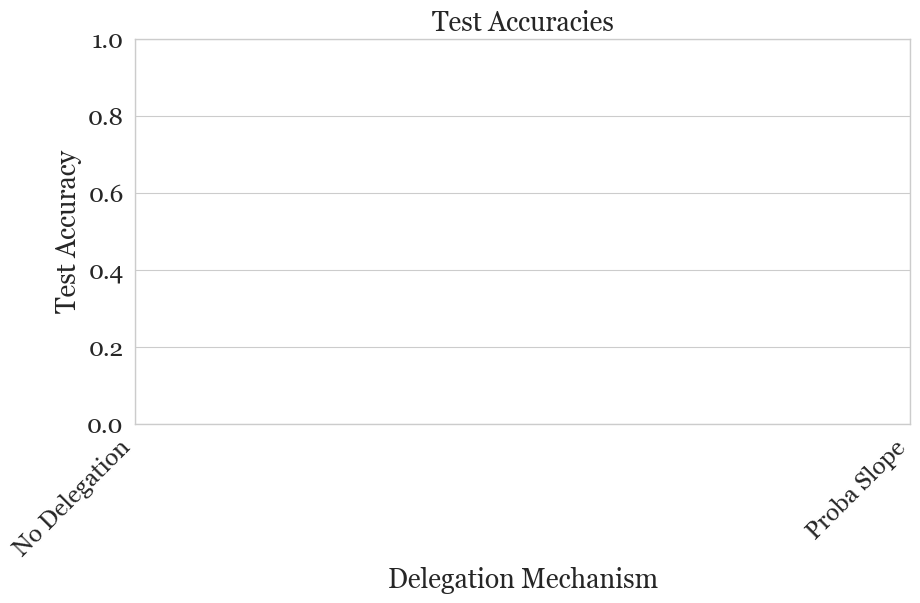

In [ ]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Georgia"

# set colors for each bar. Use pastel
colors = sns.color_palette("pastel")
# assign colors for each bar

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Test Accuracies")
ax.set_ylabel("Test Accuracy")
ax.set_xlabel("Delegation Mechanism")
# ax.set_xticks([0, 1, 2])
# ax.set_xticklabels(
#     ["No Delegation", "Proba Slope", "Restricted Max Guru"], rotation=45, ha="right"
# )
ax.set_xticks([0, 1])
ax.set_xticklabels(["No Delegation", "Proba Slope"], rotation=45, ha="right")
# Data for bar plot
means = [
    np.mean(full_avg_test_accs),
    np.mean(proba_slope_avg_test_accs),
    # np.mean(restricted_max_guru_avg_test_accs),
]
stds = [
    np.std(full_avg_test_accs),
    np.std(proba_slope_avg_test_accs),
    # np.std(restricted_max_guru_avg_test_accs),
]

# Create each bar individually to set different colors
for i in range(len(ensembles)):
    ax.bar(i, means[i], color=colors[i], yerr=stds[i], capsize=10)

plt.tight_layout()
plt.show()

In [ ]:
proba_slope_avg_train_accs, proba_slope_std_train_accs = calculate_avg_std_train_accs(
    exp, "proba_slope_delegations", num_trials
)
full_avg_train_accs, full_std_train_accs = calculate_avg_std_train_accs(
    exp, "full_ensemble", num_trials
)

# (
#     restricted_max_guru_avg_train_accs,
#     restricted_max_guru_std_train_accs,
# ) = calculate_avg_std_train_accs(exp, "restricted_max_guru_delegations", num_trials)

print(
    "Mean train accs for proba_slope delegation ensemble: ",
    np.mean(proba_slope_avg_train_accs),
)
print("Mean train accs for full ensemble: ", np.mean(full_avg_train_accs))

# print(
#     "Mean train accs for restricted_max_guru delegation ensemble: ",
#     np.mean(restricted_max_guru_avg_train_accs),
# )

In [ ]:
train_splits = exp.train_splits

In [ ]:
sns.set(style="whitegrid", palette="pastel", context="paper")

# Set the font to Georgia
mpl.rcParams["font.family"] = "Georgia"
mpl.rcParams["font.size"] = 12
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16

fig, ax = plt.subplots(figsize=(10, 5))

colors = sns.color_palette("pastel")
proba_slope_color = colors[1]
full_color = colors[0]
restricted_max_guru_color = colors[2]

ax.plot(
    proba_slope_avg_train_accs,
    label="ProbaSlope Delegation Ensemble",
    color=proba_slope_color,
    linewidth=2,
)
ax.fill_between(
    range(len(proba_slope_avg_train_accs)),
    np.array(proba_slope_avg_train_accs) - np.array(proba_slope_std_train_accs),
    np.array(proba_slope_avg_train_accs) + np.array(proba_slope_std_train_accs),
    color=proba_slope_color,
    alpha=0.3,
)

ax.plot(full_avg_train_accs, label="Full Ensemble", color=full_color, linewidth=2)
ax.fill_between(
    range(len(full_avg_train_accs)),
    np.array(full_avg_train_accs) - np.array(full_std_train_accs),
    np.array(full_avg_train_accs) + np.array(full_std_train_accs),
    color=full_color,
    alpha=0.3,
)

# ax.plot(
#     restricted_max_guru_avg_train_accs,
#     label="Restricted Max Guru Delegation Ensemble",
#     color=restricted_max_guru_color,
#     linewidth=2,
# )
# ax.fill_between(
#     range(len(restricted_max_guru_avg_train_accs)),
#     np.array(restricted_max_guru_avg_train_accs)
#     - np.array(restricted_max_guru_std_train_accs),
#     np.array(restricted_max_guru_avg_train_accs)
#     + np.array(restricted_max_guru_std_train_accs),
#     color=colors[2],
#     alpha=0.3,
# )


# plot vertical lines at test splits
for split in train_splits[:-1]:
    ax.axvline(x=split, color="k", linestyle="--", linewidth=1)

# Setting labels, title, and legend
ax.set_xlabel("Batch Number")
ax.set_ylabel("Train Accuracy")
ax.set_title(
    "ProbaSlope Delegation Ensemble vs Full Ensemble vs Restricted Max Guru Delegation Ensemble"
)

ax.legend(loc="upper left")
# set y lim to lower
ax.set_ylim(top=1.3)
# set y ticks to 0-1
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
ps_voters = exp.ensembles[1].voters
print(ensembles[1].name)
batch_accs = []
for v in ps_voters:
    batch_accs.append(v.batch_accuracies)

In [ ]:
len_train = len(data.train_data_loader.dataset) / batch_size

In [ ]:
def find_active_streaks(voter_id, trial_num):
    """
    Find active streaks for a specified voter.

    :param voter_id: ID of the voter for which to find active streaks.
    :param batch_metric_values: Dictionary containing the batch metric values.
    :param metric_key: Key to access the relevant metric in batch_metric_values.
    :return: List of active streaks for the specified voter.
    """
    active_batches = []
    active_streak = [None, None]
    voter_active = False

    for i, av in enumerate(
        exp.batch_metric_values["proba_slope_delegations"][trial_num][
            "active_voters-train"
        ]
    ):
        # print(av)
        if voter_id in av:
            if not voter_active:
                # Start a new streak
                active_streak[0] = i
                voter_active = True
                # print("streak started")
            active_streak[1] = i
        else:
            if voter_active:
                # End the current streak
                active_batches.append(active_streak.copy())
                active_streak = [None, None]
                voter_active = False
                # print("streak done")

    # Handle case where the streak continues till the end of the list
    if voter_active:
        active_batches.append(active_streak.copy())

    return active_batches

### Look at activity on last trial

In [ ]:
for voter_id in range(n_voters):
    active_streaks = find_active_streaks(voter_id, num_trials - 1)
    # print(f"Active Streaks for Voter {voter_id}: {active_streaks}")

    plt.figure(figsize=(10, 5))  # Create a new figure for each voter
    plt.plot(batch_accs[voter_id])
    plt.axvline(x=len_train, color="k", linestyle="--", linewidth=1)

    # Shade the active batches for this voter
    for streak in active_streaks:
        if streak[0] is not None and streak[1] is not None:
            plt.axvspan(streak[0], streak[1], alpha=0.3, color="red")

    # Plot a green vertical line at all train splits
    for split in train_splits[:-1]:
        plt.axvline(x=split, color="g", linestyle="--", linewidth=2)

    plt.title(f"Voter {voter_id} Activity")
    plt.xlabel("Batches")
    plt.ylabel("Accuracy")
    plt.show()  # Display the plot for each voter